# 감성사전

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
import re

In [3]:
# 라벨데이터_final -> 감성사전전처리데이터

# 분류된 뉴스 라벨부여

In [ ]:
# stock_list , df 칼럼 설정해줘야함

# 파일리스트
path = './data/1차뉴스분류/'
cate_list = os.listdir(path)

# 지수 데이터
stock_path = './data/변동률/'
stock_list = os.listdir(stock_path)

# 광고_지수.csv 반도체와반도체장비_지수.csv 석유와가스_지수.csv 자동차_지수.csv 조선_지수.csv 철강_지수.csv

# 지수데이터 1% 이상 +1, -1% 이하 -1, 0

for sto in stock_list[5:6]:  # 바꿔줘야함
    print(sto)
    data_concat = pd.DataFrame()
    stock = pd.read_csv(stock_path+sto,index_col=0)
    stock['label'] = stock['전일비'].apply(lambda x : 1 if x > 1 else (0 if x >= -1 else -1))
    
    # 분류된뉴스
    
    for cate in cate_list:
        print(cate)
        file_path = os.path.join(path, cate)
        file_list = os.listdir(file_path)

        for file in file_list:
            print(file)
            df = pd.read_csv(file_path+'/'+file, index_col=0)
            df = df[['date','news_steel']]  # 바꿔줘야함
            df.dropna(inplace=True)
            df['date'] = df['date'].astype(str).str.strip('<span>').str.strip('</span>')
            df['date'] = df['date'].str.replace('\n','').str.replace('—','')
            df['date'] = df['date'].apply(lambda x: re.findall('\(([^)]+)',x)[0] if re.findall('\(([^)]+)',x) else x )
            df['date'] = pd.to_datetime(df['date'].astype(str),utc=True)#.astype(str).apply(lambda x: x[:10]).astype('datetime64')
            df['labeldate'] = (df['date'] + np.timedelta64(13,'h')).apply(lambda x : x+ np.timedelta64(1,'D') if x.hour >= 7 else x).apply(lambda x:str(x)[:10])

            temp = pd.merge(df, stock[['Date','label']], how = 'left', left_on = 'labeldate', right_on = 'Date')

            temp.dropna(inplace=True)
            data_concat = pd.concat([data_concat,temp], ignore_index=True)
            
    data_concat.drop_duplicates(inplace=True)
    data_concat.sort_values(by='Date',inplace=True)
    data_concat.reset_index(drop=True,inplace=True)
    data_concat.to_csv('./data/라벨데이터_final/'+sto)
     

## 전처리

In [4]:
# 전처리 
def preprocessing(news):
    
    # HTML 태그 제거
    news_text = BeautifulSoup(news, "html5lib").get_text()
    
    # 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
    news_text = re.sub("[^a-zA-Z]"," ", news_text)
    
    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트화
    words = news_text.lower().split()
    
    # 어원화
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # 불용어 제거하기
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]
    
    # 한글자 없애기
    words = [w for w in words if len(w)>1]
    
    clean_news = ' '.join(words)
        
    clean_list = clean_news.split()
    clean_list.extend(' ')
    
    return clean_list

### 데이터 불러오기

In [5]:
file_path = './data/라벨데이터_final/'
file_list = os.listdir(file_path)
file_list

['광고_지수.csv',
 '반도체와반도체장비_지수.csv',
 '석유와가스_지수.csv',
 '자동차_지수.csv',
 '조선_지수.csv',
 '철강_지수.csv']

In [6]:
df = pd.read_csv(file_path+ '반도체와반도체장비_지수.csv',index_col=0)
df.head()

,date,news_sc,labeldate,Date,label
0,2020-09-08 04:50:00+00:00,LONDON (Reuters) - The number of merger and ac...,2020-09-09,2020-09-09,-1.0
1,2020-09-24 00:36:00+00:00,(Bloomberg) -- Euro-zone banks are gearing up ...,2020-09-25,2020-09-25,-1.0
2,2021-04-21 20:10:00+00:00,"By Diane Bartz, Stephen Nellis and Paresh Dave...",2021-04-23,2021-04-23,0.0
3,2021-07-08 11:11:00+00:00,By Fabian Cambero\nSANTIAGO (Reuters) - The ec...,2021-07-09,2021-07-09,-1.0
4,2021-08-17 16:45:00+00:00,By Jonathan Stempel\nNEW YORK (Reuters) - The ...,2021-08-18,2021-08-18,1.0


In [7]:
for file in file_list:
    print(file)
    df = pd.read_csv(file_path + file,index_col=0)

광고_지수.csv
반도체와반도체장비_지수.csv
석유와가스_지수.csv
자동차_지수.csv
조선_지수.csv
철강_지수.csv


### 토큰화

In [8]:
# 뉴스기사 토큰화
df['clean_news'] = df.iloc[:,1].apply(preprocessing)
df

,date,news_oil,labeldate,Date,label,clean_news
0,2022-04-17 03:32:00+00:00,By Barani Krishnan\nInvesting.com -- Will they...,2022-04-18,2022-04-18,0.0,"[barani, krishnan, invest, com, europ, forthco..."
1,2022-04-17 00:41:00+00:00,MEXICO CITY (Reuters) -Mexican state oil compa...,2022-04-18,2022-04-18,0.0,"[mexico, citi, reuter, mexican, state, oil, co..."
2,2022-04-14 17:31:00+00:00,By Jarrett Renshaw and Jeff Mason\n(Reuters) -...,2022-04-15,2022-04-15,0.0,"[jarrett, renshaw, jeff, mason, reuter, white,..."
3,2022-04-14 15:24:00+00:00,By Barani Krishnan\nInvesting.com -- Any sello...,2022-04-15,2022-04-15,0.0,"[barani, krishnan, invest, com, ani, selloff, ..."
4,2022-04-14 15:21:00+00:00,By Arathy Somasekhar\nHOUSTON -Oil prices sett...,2022-04-15,2022-04-15,0.0,"[arathi, somasekhar, houston, oil, price, sett..."
...,...,...,...,...,...,...
1541,2021-06-10 09:37:00+00:00,By Peter Nurse \nInvesting.com -- Crude oil ...,2021-06-11,2021-06-11,0.0,"[peter, nurs, invest, com, crude, oil, price, ..."
1542,2021-06-10 01:46:00+00:00,(Reuters) -A $9 billion oil pipeline that beca...,2021-06-11,2021-06-11,0.0,"[reuter, billion, oil, pipelin, becam, symbol,..."
1543,2021-06-10 00:53:00+00:00,By Gina Lee\nInvesting.com – Oil was down Thur...,2021-06-11,2021-06-11,0.0,"[gina, lee, invest, com, oil, wa, thursday, mo..."
1544,2021-06-09 20:09:00+00:00,(Bloomberg) -- Oil edged lower in Asia as risi...,2021-06-11,2021-06-11,0.0,"[bloomberg, oil, edg, lower, asia, rise, fuel,..."


## 전처리 과정 하나로 합친 코드



In [28]:
## 라벨데이터 -> 감성사전전치리데이터

# 전처리 
def preprocessing(news):
    
    # HTML 태그 제거
    news_text = BeautifulSoup(news, "html5lib").get_text()
    
    # 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
    news_text = re.sub("[^a-zA-Z]"," ", news_text)
    
    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트화
    words = news_text.lower().split()
    
    # 어원화
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # 불용어 제거하기
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]
    
    # 한글자 없애기
    words = [w for w in words if len(w)>1]
    
    clean_news = ' '.join(words)
        
    clean_list = clean_news.split()
    clean_list.extend(' ')
    
    return clean_list

file_path = './data/라벨데이터_final/'
file_list = os.listdir(file_path)

for file in file_list:
    print(file)
    df = pd.read_csv(file_path + file,index_col=0)
    df['clean_news'] = df.iloc[:,1].apply(preprocessing)
    df.sort_values(by='Date',inplace=True)
    df.to_csv('./data/감성사전전처리데이터/{}'.format(file))
    

광고_지수.csv
반도체와반도체장비_지수.csv
석유와가스_지수.csv
자동차_지수.csv
조선_지수.csv
철강_지수.csv


In [29]:
df

,date,news_steel,labeldate,Date,label,clean_news


# 감성사전 만들기

## 반도체

In [216]:
df =pd.read_csv('./data/감성사전전처리데이터/반도체와반도체장비_지수.csv',index_col=0)
df.head()

,date,news_sc,labeldate,Date,label,clean_news
0,2020-09-08 04:50:00+00:00,LONDON (Reuters) - The number of merger and ac...,2020-09-09,2020-09-09,-1.0,"['london', 'reuter', 'number', 'merger', 'acqu..."
1,2020-09-24 00:36:00+00:00,(Bloomberg) -- Euro-zone banks are gearing up ...,2020-09-25,2020-09-25,-1.0,"['bloomberg', 'euro', 'zone', 'bank', 'gear', ..."
2,2021-04-21 20:10:00+00:00,"By Diane Bartz, Stephen Nellis and Paresh Dave...",2021-04-23,2021-04-23,0.0,"['dian', 'bartz', 'stephen', 'nelli', 'paresh'..."
3,2021-07-08 11:11:00+00:00,By Fabian Cambero\nSANTIAGO (Reuters) - The ec...,2021-07-09,2021-07-09,-1.0,"['fabian', 'cambero', 'santiago', 'reuter', 'e..."
4,2021-08-17 16:45:00+00:00,By Jonathan Stempel\nNEW YORK (Reuters) - The ...,2021-08-18,2021-08-18,1.0,"['jonathan', 'stempel', 'new', 'york', 'reuter..."


In [217]:
def kw_tolist(words):
    kw_list = re.sub('[^A-Za-z ]',"",words).split()
    return kw_list

In [218]:
df['kw_list'] = df['clean_news'].apply(kw_tolist)
words_cnt = pd.Series(df['kw_list'][0]).value_counts() 
words_cnt

pound         4
compani       4
billion       4
quarter       3
deal          3
involv        3
british       3
first         3
foreign       2
valu          2
said          2
statist       2
acquir        2
one           1
end           1
sinc          1
lowest        1
offic         1
nation        1
slight        1
total         1
increas       1
three         1
month         1
london        1
reuter        1
countri       1
restrict      1
coronaviru    1
peak          1
dure          1
second        1
sharpli       1
fell          1
acquisit      1
merger        1
number        1
year          1
dtype: int64

In [219]:
senti_dic = dict()

for d in range(len(df['Date'])):  # 날짜
    
    # 하루뉴스의 단어 빈도수 series
    words_cnt = pd.Series(df['kw_list'][d]).value_counts()   

    # 단어이름
    words = words_cnt.index

    for word in words:

        #딕셔너리에 없는 단어일 경우 (처음 빈도수값*변동률) 대입
        if word not in senti_dic:
            senti_dic[word] = words_cnt.loc[word] * df['label'][d]

        # 기존에 있는 단어라면 기존꺼에 추가
        else:
            senti_dic[word] += words_cnt.loc[word] * df['label'][d]

senti_dic

{'pound': -12.0,
 'compani': 8.0,
 'billion': -30.0,
 'quarter': -2.0,
 'deal': -20.0,
 'involv': 4.0,
 'british': -9.0,
 'first': -9.0,
 'foreign': 11.0,
 'valu': -5.0,
 'said': -9.0,
 'statist': -2.0,
 'acquir': -4.0,
 'one': 3.0,
 'end': -15.0,
 'sinc': 4.0,
 'lowest': -3.0,
 'offic': -5.0,
 'nation': 13.0,
 'slight': -3.0,
 'total': 1.0,
 'increas': 2.0,
 'three': -8.0,
 'month': -6.0,
 'london': -13.0,
 'reuter': 5.0,
 'countri': 6.0,
 'restrict': -7.0,
 'coronaviru': -2.0,
 'peak': -1.0,
 'dure': -5.0,
 'second': -9.0,
 'sharpli': -1.0,
 'fell': -7.0,
 'acquisit': -8.0,
 'merger': -7.0,
 'number': 5.0,
 'year': -29.0,
 'bank': -33.0,
 'rate': -14.0,
 'euro': -23.0,
 'ecb': -6.0,
 'thi': -21.0,
 'trillion': -7.0,
 'anoth': -6.0,
 'lend': -5.0,
 'ha': 8.0,
 'market': -15.0,
 'economi': -6.0,
 'polici': 3.0,
 'time': 9.0,
 'minu': -3.0,
 'cut': 1.0,
 'could': -4.0,
 'borrow': -3.0,
 'plc': -2.0,
 'estim': -11.0,
 'bloomberg': -9.0,
 'liquid': -2.0,
 'record': -6.0,
 'deposit': -2.0,

In [220]:
# 감성사전
df_score = pd.DataFrame(senti_dic, index=[0]).transpose()
df_score.reset_index(inplace=True)
df_score

,index,0
0,pound,-12.0
1,compani,8.0
2,billion,-30.0
3,quarter,-2.0
4,deal,-20.0
...,...,...
3667,blockbust,-1.0
3668,witcher,-1.0
3669,wild,-1.0
3670,hunt,-1.0


In [221]:
# 기존의 감성사전 단어에 포함된 단어만 추출

df_fin = pd.read_csv('./data/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
fin_list = df_fin['Word'].str.lower().tolist()

In [222]:
# 기존의 감성사전 단어에 포함된 단어만 추출

df_fin = pd.read_csv('./data/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
fin_list = df_fin['Word'].str.lower().tolist()

# Loughran-McDonald 감성사전에 있는 단어만 사용

df_senti2 = df_score[df_score['index'].apply(lambda x : x in fin_list)]
df_senti2 = df_senti2.sort_values(by=0)
df_senti2

,index,0
245,nyse,-55.0
38,bank,-33.0
2,billion,-30.0
320,data,-29.0
37,year,-29.0
...,...,...
502,unit,20.0
1711,robot,25.0
733,research,30.0
523,report,33.0


### 단어별 점수 분포 확인

<AxesSubplot:xlabel='index'>

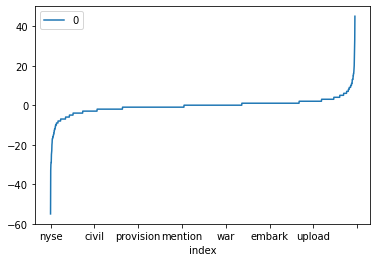

In [223]:
df_senti2.set_index('index').plot()

In [224]:
df_senti2.describe()

,0
count,1738.000000
mean,-0.352704
std,4.382989
min,-55.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,45.000000


### 너무 큰값 제한하기

In [225]:
# 최대 20 최소 -20 으로 제한
df_senti2[0] = df_senti2[0].apply(lambda x : 20 if x > 20 else (x if x > -20 else -20 ))
df_senti2

,index,0
245,nyse,-20.0
38,bank,-20.0
2,billion,-20.0
320,data,-20.0
37,year,-20.0
...,...,...
502,unit,20.0
1711,robot,20.0
733,research,20.0
523,report,20.0


<AxesSubplot:xlabel='index'>

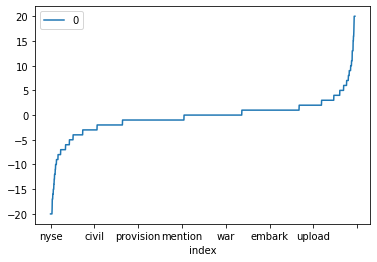

In [45]:
df_senti2.set_index('index').plot()

In [33]:
senti_words = df_senti2['index'].values # 감정사전 단어
senti_score = df_senti2[0] # 감정사전 점수

In [47]:
df_senti2.to_csv('./data/감성사전/반도체감성사전.csv')

## 자동차

In [359]:
df =pd.read_csv('./data/감성사전전처리데이터/자동차_지수.csv',index_col=0)
def kw_tolist(words):
    kw_list = re.sub('[^A-Za-z ]',"",words).split()
    return kw_list
df['kw_list'] = df['clean_news'].apply(kw_tolist)
words_cnt = pd.Series(df['kw_list'][0]).value_counts() 

senti_dic = dict()

for d in range(len(df['Date'])):  # 날짜
    
    # 하루뉴스의 단어 빈도수 series
    words_cnt = pd.Series(df['kw_list'][d]).value_counts()   

    # 단어이름
    words = words_cnt.index

    for word in words:

        #딕셔너리에 없는 단어일 경우 (처음 빈도수값*변동률) 대입
        if word not in senti_dic:
            senti_dic[word] = words_cnt.loc[word] * df['label'][d]

        # 기존에 있는 단어라면 기존꺼에 추가
        else:
            senti_dic[word] += words_cnt.loc[word] * df['label'][d]

senti_dic

{'bloomberg': 6.0,
 'good': 15.0,
 'juli': 11.0,
 'month': 33.0,
 'estim': 16.0,
 'order': 38.0,
 'rose': 2.0,
 'durabl': -1.0,
 'depart': 4.0,
 'data': 4.0,
 'core': 10.0,
 'show': 12.0,
 'wednesday': -4.0,
 'median': -2.0,
 'survey': -2.0,
 'economist': 12.0,
 'call': 16.0,
 'gain': 14.0,
 'exclud': 0.0,
 'capit': 13.0,
 'categori': -2.0,
 'june': 9.0,
 'aircraft': 3.0,
 'militari': -1.0,
 'hardwar': -1.0,
 'seen': 1.0,
 'baromet': -1.0,
 'busi': 16.0,
 'invest': 24.0,
 'slightli': -1.0,
 'commerc': 4.0,
 'year': 31.0,
 'jump': 2.0,
 'support': 10.0,
 'doubl': 5.0,
 'amid': -1.0,
 'continu': 24.0,
 'surg': 4.0,
 'automobil': -1.0,
 'demand': 21.0,
 'indic': 0.0,
 'factori': 23.0,
 'help': -4.0,
 'econom': 7.0,
 'prior': 4.0,
 'rebound': 6.0,
 'come': 16.0,
 'book': 0.0,
 'item': 3.0,
 'meant': 0.0,
 'last': 35.0,
 'least': -2.0,
 'three': 16.0,
 'increas': 34.0,
 'forecast': 3.0,
 'sale': 8.0,
 'vehicl': 106.0,
 'august': -6.0,
 'said': 117.0,
 'china': 17.0,
 'nev': 2.0,
 'ev': 87.0

In [360]:
# 감성사전
df_score = pd.DataFrame(senti_dic, index=[0]).transpose()
df_score.reset_index(inplace=True)
df_score

,index,0
0,bloomberg,6.0
1,good,15.0
2,juli,11.0
3,month,33.0
4,estim,16.0
...,...,...
5448,notorieti,1.0
5449,falsiti,1.0
5450,docket,1.0
5451,narr,1.0


In [361]:
# 기존의 감성사전 단어에 포함된 단어만 추출

df_fin = pd.read_csv('./data/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
fin_list = df_fin['Word'].str.lower().tolist()

df_senti2 = df_score[df_score['index'].apply(lambda x : x in fin_list)]
df_senti2 = df_senti2.sort_values(by=0)
df_senti2

,index,0
181,home,-20.0
1720,album,-12.0
5172,kinder,-10.0
2070,prosecutor,-10.0
1650,crash,-9.0
...,...,...
750,billion,65.0
260,ha,72.0
1826,twitter,110.0
58,said,117.0


<AxesSubplot:xlabel='index'>

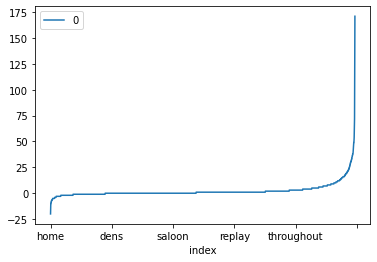

In [362]:
df_senti2.set_index('index').plot()

In [363]:
# # 최대 20 최소 -20 으로 제한
# df_senti2[0] = df_senti2[0].apply(lambda x : 20 if x > 20 else (x if x > -20 else -20 ))
# df_senti2

In [364]:
# df_senti2.to_csv('./data/감성사전/자동차감성사전_조정.csv')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00,
        7.000e+00, 2.100e+01, 5.000e+01, 3.620e+02, 1.308e+03, 1.950e+02,
        1.840e+02, 9.200e+01, 6.400e+01, 4.200e+01, 2.900e+01, 1.700e+01,
        2.300e+01, 1.000e+01, 1.300e+01, 1.000e+01, 4.000e+00, 5.000e+00,
        4.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

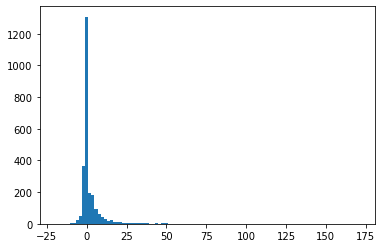

In [365]:
plt.hist(df_senti2.set_index('index'),bins=100)

In [366]:
# 최대 0.3 최소 -1 으로 제한
df_senti2[0] = df_senti2[0].apply(lambda x : 0.3 if x > 0.3 else (x if x > -1 else -1 ))
df_senti2

,index,0
181,home,-1.0
1720,album,-1.0
5172,kinder,-1.0
2070,prosecutor,-1.0
1650,crash,-1.0
...,...,...
750,billion,0.3
260,ha,0.3
1826,twitter,0.3
58,said,0.3


In [367]:
df_senti2.to_csv('./data/감성사전/자동차감성사전_조정2.csv')

## 석유와가스

In [356]:
df =pd.read_csv('./data/감성사전전처리데이터/석유와가스_지수.csv',index_col=0)
def kw_tolist(words):
    kw_list = re.sub('[^A-Za-z ]',"",words).split()
    return kw_list
df['kw_list'] = df['clean_news'].apply(kw_tolist)
words_cnt = pd.Series(df['kw_list'][0]).value_counts() 

senti_dic = dict()

for d in range(len(df['Date'])):  # 날짜
    
    # 하루뉴스의 단어 빈도수 series
    words_cnt = pd.Series(df['kw_list'][d]).value_counts()   

    # 단어이름
    words = words_cnt.index

    for word in words:

        #딕셔너리에 없는 단어일 경우 (처음 빈도수값*변동률) 대입
        if word not in senti_dic:
            senti_dic[word] = words_cnt.loc[word] * df['label'][d]

        # 기존에 있는 단어라면 기존꺼에 추가
        else:
            senti_dic[word] += words_cnt.loc[word] * df['label'][d]

senti_dic

{'turkey': -2.0,
 'syria': 6.0,
 'assault': 6.0,
 'presid': 56.0,
 'forc': -3.0,
 'agre': 8.0,
 'day': 11.0,
 'syrian': 3.0,
 'penc': 0.0,
 'mike': -2.0,
 'isi': 1.0,
 'meet': -10.0,
 'kurdish': 1.0,
 'five': -5.0,
 'ceasefir': 6.0,
 'withdraw': 2.0,
 'border': -1.0,
 'report': 29.0,
 'trump': -2.0,
 'turkish': 6.0,
 'reemerg': 0.0,
 'group': 26.0,
 'fear': -7.0,
 'terrorist': 11.0,
 'caus': -4.0,
 'could': 12.0,
 'media': 34.0,
 'mani': 20.0,
 'region': -14.0,
 'troop': -34.0,
 'critic': 8.0,
 'widespread': 0.0,
 'face': 19.0,
 'recent': 0.0,
 'member': -7.0,
 'suggest': 3.0,
 'msci': 1.0,
 'tri': 10.0,
 'usd': 7.0,
 'wa': 88.0,
 'tur': 0.0,
 'nasdaq': -11.0,
 'etf': 2.0,
 'ishar': 1.0,
 'hundr': 11.0,
 'move': 1.0,
 'kurd': 0.0,
 'prison': -13.0,
 'escap': 1.0,
 'noth': 9.0,
 'captur': 5.0,
 'ha': 34.0,
 'invest': 3.0,
 'militari': -2.0,
 'vice': 0.0,
 'told': 25.0,
 'allow': 3.0,
 'halt': -3.0,
 'pompeo': 0.0,
 'state': 47.0,
 'secretari': 1.0,
 'follow': 12.0,
 'said': 106.0,
 'erd

In [231]:
# 감성사전 폴더에 저장
df_score = pd.DataFrame(senti_dic, index=[0]).transpose()
df_score.reset_index(inplace=True)
df_score

,index,0
0,turkey,-2.0
1,syria,6.0
2,assault,6.0
3,presid,56.0
4,forc,-3.0
...,...,...
20390,willow,0.0
20391,pussi,0.0
20392,okhtyrka,0.0
20393,suspiln,0.0


<AxesSubplot:xlabel='index'>

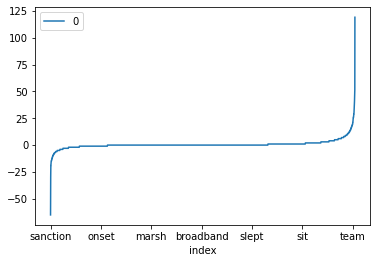

In [232]:
# 기존의 감성사전 단어에 포함된 단어만 추출

df_fin = pd.read_csv('./data/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
fin_list = df_fin['Word'].str.lower().tolist()

df_senti2 = df_score[df_score['index'].apply(lambda x : x in fin_list)]
df_senti2 = df_senti2.sort_values(by=0)
df_senti2

df_senti2.set_index('index').plot()

In [63]:
# # 최대 20 최소 -20 으로 제한
# df_senti2[0] = df_senti2[0].apply(lambda x : 20 if x > 20 else (x if x > -20 else -20 ))
# df_senti2

,index,0
840,sanction,-20.0
29,troop,-20.0
876,flight,-20.0
587,china,-20.0
2864,sea,-20.0
...,...,...
1299,call,20.0
263,month,20.0
93,govern,20.0
62,said,20.0


In [64]:
# df_senti2.to_csv('./data/감성사전/석유와가스감성사전_조정.csv')

In [233]:
# 최대 5 최소 -5 으로 제한
df_senti2[0] = df_senti2[0].apply(lambda x : 5 if x > 5 else (x if x > -5 else -5 ))
df_senti2

,index,0
840,sanction,-5.0
29,troop,-5.0
876,flight,-5.0
587,china,-5.0
2864,sea,-5.0
...,...,...
1299,call,5.0
263,month,5.0
93,govern,5.0
62,said,5.0


In [234]:
df_senti2.to_csv('./data/감성사전/석유와가스감성사전_조정5.csv')

# 감성점수기반 당일뉴스의 점수 

## 당일 Oil  뉴스전처리

In [235]:
# 당일 분류된 뉴스데이터

df = pd.read_csv('./data/당일뉴스/당일뉴스분류_0422.csv',index_col=0)
df.head()

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others
0,2022-04-22,"As a candidate, Joe Biden made climate change ...",NaN,NaN,NaN,NaN,NaN
1,2022-04-22,By David Gaffen\nNEW YORK (Reuters) -Oil price...,NaN,NaN,NaN,NaN,NaN
2,2022-04-22,By Barani Krishnan\nInvesting.com -- Oil price...,NaN,NaN,NaN,NaN,NaN
3,2022-04-22,NaN,NaN,NaN,NaN,NaN,(Bloomberg) -- The U.S. West Coast is importin...
4,2022-04-22,U.S. companies can help rebuild Ukraine with d...,NaN,NaN,NaN,NaN,NaN


In [236]:
# 전처리

# 전처리 
def preprocessing(news):
    
    # HTML 태그 제거
    news_text = BeautifulSoup(news, "html5lib").get_text()
    
    # 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
    news_text = re.sub("[^a-zA-Z]"," ", news_text)
    
    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트화
    words = news_text.lower().split()
    
    # 어원화
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # 불용어 제거하기
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]
    
    # 한글자 없애기
    words = [w for w in words if len(w)>1]
    
    clean_news = ' '.join(words)
        
    clean_list = clean_news.split()
    clean_list.extend(' ')
    
    return clean_list

In [238]:
df.dropna(subset='news_oil',inplace=True)
df.drop_duplicates(subset='news_oil',inplace=True)
df

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others
0,2022-04-22,"As a candidate, Joe Biden made climate change ...",NaN,NaN,NaN,NaN,NaN
1,2022-04-22,By David Gaffen\nNEW YORK (Reuters) -Oil price...,NaN,NaN,NaN,NaN,NaN
2,2022-04-22,By Barani Krishnan\nInvesting.com -- Oil price...,NaN,NaN,NaN,NaN,NaN
4,2022-04-22,U.S. companies can help rebuild Ukraine with d...,NaN,NaN,NaN,NaN,NaN
14,2022-04-22,The San Francisco Bay will soon have a new fos...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
238,2022-04-22,"More than 600,000 additional people were inter...",NaN,NaN,NaN,NaN,NaN
239,2022-04-22,President Vladimir Putin has once again promot...,NaN,NaN,NaN,NaN,NaN
244,2022-04-22,G7 finance ministers said they have provided a...,NaN,NaN,NaN,NaN,NaN
246,2022-04-22,President Joe Biden convened U.S. military lea...,NaN,NaN,NaN,NaN,NaN


In [239]:
df['clean_news'] = df.iloc[:,1].apply(preprocessing)
df

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others,clean_news
0,2022-04-22,"As a candidate, Joe Biden made climate change ...",NaN,NaN,NaN,NaN,NaN,"[candid, joe, biden, made, climat, chang, pill..."
1,2022-04-22,By David Gaffen\nNEW YORK (Reuters) -Oil price...,NaN,NaN,NaN,NaN,NaN,"[david, gaffen, new, york, reuter, oil, price,..."
2,2022-04-22,By Barani Krishnan\nInvesting.com -- Oil price...,NaN,NaN,NaN,NaN,NaN,"[barani, krishnan, invest, com, oil, price, ro..."
4,2022-04-22,U.S. companies can help rebuild Ukraine with d...,NaN,NaN,NaN,NaN,NaN,"[compani, help, rebuild, ukrain, digit, infras..."
14,2022-04-22,The San Francisco Bay will soon have a new fos...,NaN,NaN,NaN,NaN,NaN,"[san, francisco, bay, soon, new, fossil, fuel,..."
...,...,...,...,...,...,...,...,...
238,2022-04-22,"More than 600,000 additional people were inter...",NaN,NaN,NaN,NaN,NaN,"[addit, peopl, intern, displac, ukrain, first,..."
239,2022-04-22,President Vladimir Putin has once again promot...,NaN,NaN,NaN,NaN,NaN,"[presid, vladimir, putin, ha, onc, promot, rus..."
244,2022-04-22,G7 finance ministers said they have provided a...,NaN,NaN,NaN,NaN,NaN,"[financ, minist, said, provid, pledg, togeth, ..."
246,2022-04-22,President Joe Biden convened U.S. military lea...,NaN,NaN,NaN,NaN,NaN,"[presid, joe, biden, conven, militari, leader,..."


### 당일 카테고리뉴스 점수구하기

In [240]:
# 감성사전 불러오기
df_senti2 = pd.read_csv('./data/감성사전/석유와가스감성사전_조정5.csv',index_col=0)
df_senti2

,index,0
840,sanction,-5.0
29,troop,-5.0
876,flight,-5.0
587,china,-5.0
2864,sea,-5.0
...,...,...
1299,call,5.0
263,month,5.0
93,govern,5.0
62,said,5.0


In [241]:
senti_score = df_senti2['0'] # 감정사전 점수

In [242]:
len(df['clean_news'].iloc[0])

177

### 당일 감성점수

In [243]:
senti_words = df_senti2['index'].values # 감정사전 단어

# df: 당일기사 모음

score_today_oil = 0
for d in range(len(df)):
    news_words = df['clean_news'].iloc[d]  # (행별) 기사하나의 단어들
    
    for word in news_words:
        if word in senti_words:
            score_today_oil += df_senti2[df_senti2['index']== word].iloc[0,1]
        else:
            pass

score_today_oil

10724.0

### 과거 Oil 감성점수 리스트

In [244]:
df_past = pd.read_csv('./data/라벨데이터_final/석유와가스_지수.csv',index_col=0)
df_past

,date,news_oil,labeldate,Date,label
0,2019-10-17 14:21:00+00:00,Investing.com – Turkish assets rose Thursday a...,2019-10-18,2019-10-18,0.0
1,2019-10-21 15:36:00+00:00,(Bloomberg) -- Explore what’s moving the globa...,2019-10-22,2019-10-22,0.0
2,2019-10-28 15:08:00+00:00,Investing.com - U.K. Prime Minister Boris John...,2019-10-29,2019-10-29,0.0
3,2019-11-04 00:24:00+00:00,Investing.com - The British Pound was little c...,2019-11-05,2019-11-05,0.0
4,2019-11-06 20:16:00+00:00,By Jonathan Cable\nLONDON (Reuters) - Sterling...,2019-11-08,2019-11-08,0.0
...,...,...,...,...,...
2780,2022-04-16 18:05:00+00:00,FRANKFURT (Reuters) - The European Union's for...,2022-04-18,2022-04-18,0.0
2781,2022-04-17 11:25:00+00:00,By Kanishka Singh\nWASHINGTON (Reuters) -Ukrai...,2022-04-18,2022-04-18,0.0
2782,2022-04-17 06:05:00+00:00,By Panu Wongcha-um\nBANGKOK (Reuters) - Ramada...,2022-04-18,2022-04-18,0.0
2783,2022-04-17 20:21:00+00:00,(Reuters) - Ukraine has completed a questionna...,2022-04-19,2022-04-19,0.0


In [245]:
df_past1 = df_past.groupby('Date')[['Date','news_oil']].sum()
df_past1

,Date,news_oil
Date,,
2019-10-18,2019-10-18,Investing.com – Turkish assets rose Thursday a...
2019-10-22,2019-10-22,(Bloomberg) -- Explore what’s moving the globa...
2019-10-29,2019-10-29,Investing.com - U.K. Prime Minister Boris John...
2019-11-05,2019-11-05,Investing.com - The British Pound was little c...
2019-11-08,2019-11-08,By Jonathan Cable\nLONDON (Reuters) - Sterling...
...,...,...
2022-04-13,2022-04-132022-04-132022-04-132022-04-132022-0...,By Eric M. Johnson\nSEATTLE (Reuters) -Boeing ...
2022-04-14,2022-04-142022-04-142022-04-142022-04-142022-0...,"By Steve Holland and Jeff Mason\nDES MOINES, I..."
2022-04-15,2022-04-152022-04-152022-04-152022-04-152022-0...,WASHINGTON (Reuters) - U.S. import prices acce...


In [246]:
# 전처리
df_past1['clean_news'] = df_past1.iloc[:,1].apply(preprocessing)

In [247]:
df_senti2

,index,0
840,sanction,-5.0
29,troop,-5.0
876,flight,-5.0
587,china,-5.0
2864,sea,-5.0
...,...,...
1299,call,5.0
263,month,5.0
93,govern,5.0
62,said,5.0


In [248]:
df_senti2[df_senti2['index']== 'china'].iloc[0,1]

-5.0

### 과거 Oil 감성점수 리스트

In [249]:
senti_words = df_senti2['index'].values # 감정사전 단어

senti_lst_oil = []


for d in range(len(df_past1)): #len(df_past1)
    news_words = df_past1['clean_news'].iloc[d] # (행별) 하루의 기사총합의 단어들
    
    score = 0
    for word in news_words:
        if word in senti_words: # 단어가 감성사전단어 목록에 있으면
            score += df_senti2[df_senti2['index']== word].iloc[0,1] # 감성사전 단어 점수 더하기
        else:
            continue
    
    senti_lst_oil.append(score)

senti_lst_oil

[50.0,
 555.0,
 173.0,
 233.0,
 335.0,
 150.0,
 224.0,
 360.0,
 253.0,
 136.0,
 79.0,
 233.0,
 172.0,
 600.0,
 617.0,
 119.0,
 139.0,
 239.0,
 175.0,
 392.0,
 1215.0,
 158.0,
 148.0,
 119.0,
 330.0,
 337.0,
 190.0,
 124.0,
 122.0,
 269.0,
 216.0,
 87.0,
 249.0,
 277.0,
 668.0,
 275.0,
 112.0,
 303.0,
 211.0,
 61.0,
 193.0,
 430.0,
 207.0,
 228.0,
 1123.0,
 209.0,
 499.0,
 624.0,
 201.0,
 203.0,
 284.0,
 555.0,
 181.0,
 236.0,
 318.0,
 617.0,
 785.0,
 208.0,
 51.0,
 281.0,
 143.0,
 110.0,
 169.0,
 1330.0,
 138.0,
 127.0,
 225.0,
 179.0,
 891.0,
 572.0,
 285.0,
 64.0,
 125.0,
 45.0,
 827.0,
 561.0,
 952.0,
 658.0,
 315.0,
 433.0,
 976.0,
 793.0,
 970.0,
 47.0,
 767.0,
 922.0,
 378.0,
 869.0,
 875.0,
 1643.0,
 515.0,
 295.0,
 1363.0,
 605.0,
 1638.0,
 330.0,
 143.0,
 1819.0,
 1006.0,
 121.0,
 626.0,
 256.0,
 941.0,
 235.0,
 226.0,
 585.0,
 589.0,
 1393.0,
 267.0,
 1044.0,
 1334.0,
 764.0,
 123.0,
 666.0,
 749.0,
 203.0,
 162.0,
 724.0,
 859.0,
 300.0,
 516.0,
 215.0,
 437.0,
 933.0,
 120.

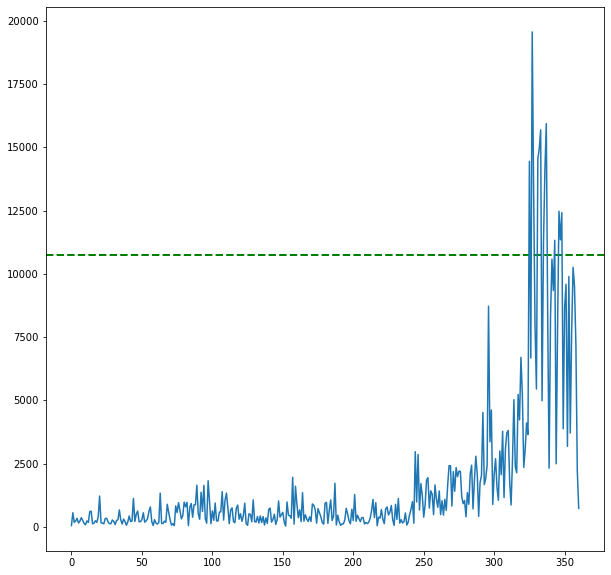

In [250]:
# 날짜별 감성점수
plt.figure(figsize=(10,10))
plt.axhline(score_today_oil, color='green', linestyle='--', linewidth=2)
plt.plot(senti_lst_oil)

### 정규화

In [176]:
senti_lst_oil1 = pd.Series(senti_lst_oil)
senti_scaled_oil = (senti_lst_oil1- senti_lst_oil1.mean())/senti_lst_oil1.std()
senti_scaled_oil

0     -0.549458
1     -0.412581
2     -0.523432
3     -0.502868
4     -0.463883
         ...   
356    2.849753
357    2.483463
358    1.984795
359    0.153026
360   -0.327863
Length: 361, dtype: float64

In [182]:
# 당일 점수 정규화
score_today_oil1 = (score_today_oil- senti_lst_oil1.mean())/senti_lst_oil1.std()
score_today_oil1

3.0113699837480765

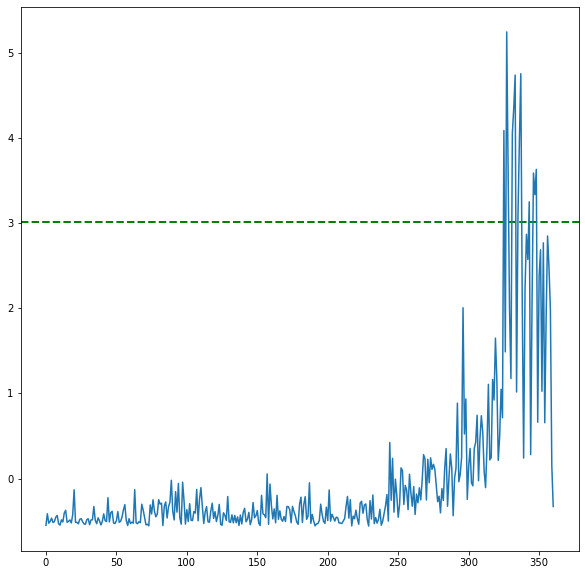

In [183]:
plt.figure(figsize=(10,10))
plt.axhline(score_today_oil1, color='green', linestyle='--', linewidth=2)
plt.plot(senti_scaled_oil)

### 석유주 데이터와 비교

In [185]:
df_oil = pd.read_csv('./data/변동률/석유와가스_지수.csv',index_col=0)
df_oil.head()

,Date,극동유화,경동인베스트,세원이앤씨,SK이노베이션,이아이디,SK디스커버리,에스아이리소스,흥구석유,한국쉘석유,미창석유,GS,중앙에너비스,S-Oil,total,지수,전일비
0,2008-01-02,2.205205e+11,5.266557e+12,5.693112e+12,9.342166e+14,3.075290e+14,4.111719e+13,1.658038e+12,6.337229e+10,4.793600e+12,2.609565e+12,2.504746e+14,6.612896e+10,1.537336e+14,1.707442e+15,100.000000,NaN
1,2008-01-03,2.205205e+11,5.258042e+12,5.521703e+12,8.797206e+14,3.046549e+14,3.926132e+13,1.677157e+12,5.919514e+10,4.823598e+12,2.593306e+12,2.443009e+14,6.725744e+10,1.549684e+14,1.643127e+15,96.233259,-3.766741
2,2008-01-04,2.154627e+11,5.232317e+12,5.652091e+12,8.485801e+14,3.104031e+14,3.841706e+13,1.658038e+12,5.943974e+10,4.859595e+12,2.520141e+12,2.407731e+14,6.792125e+10,1.564090e+14,1.614847e+15,94.577004,-1.656255
3,2008-01-07,2.184974e+11,5.223802e+12,5.542214e+12,8.174395e+14,2.989067e+14,3.926132e+13,1.581758e+12,5.797210e+10,4.835597e+12,2.422587e+12,2.284258e+14,6.778849e+10,1.566148e+14,1.560598e+15,91.399793,-3.177211
4,2008-01-08,2.154627e+11,5.292193e+12,5.432336e+12,8.563652e+14,3.017808e+14,4.083577e+13,1.457878e+12,5.864947e+10,4.805600e+12,2.495753e+12,2.416551e+14,6.752296e+10,1.564090e+14,1.616871e+15,94.695537,3.295744


In [191]:
df_oil1 = df_oil[['Date','전일비']]
df_oil1['Date'] = df_oil1['Date'].astype('datetime64')
df_oil2 = df_oil1.set_index('Date')
df_oil2.head()

C:\Users\21ckw\AppData\Local\Temp/ipykernel_4760/1468497980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil1['Date'] = df_oil1['Date'].astype('datetime64')


,전일비
Date,
2008-01-02,NaN
2008-01-03,-3.766741
2008-01-04,-1.656255
2008-01-07,-3.177211
2008-01-08,3.295744


In [214]:
oil_diff = df_oil2['2019-10-18':]
oil_diff

,전일비
Date,
2019-10-18,-0.132760
2019-10-21,-0.895152
2019-10-22,1.490509
2019-10-23,-1.396310
2019-10-24,1.858783
...,...
2022-04-13,2.430165
2022-04-14,1.103000
2022-04-15,-0.340995


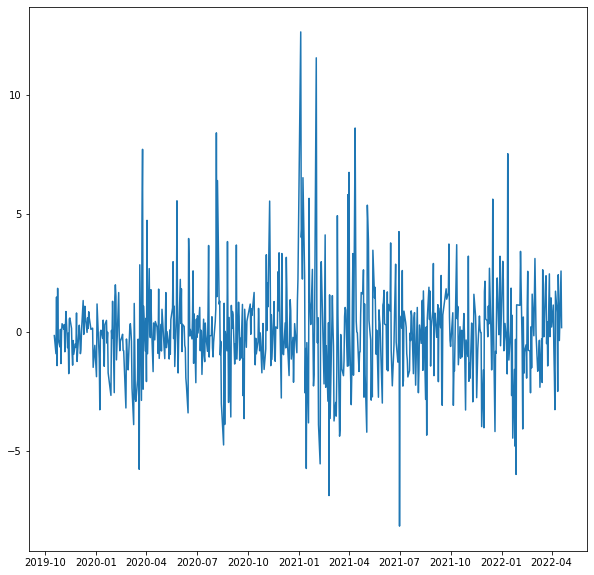

In [215]:
plt.figure(figsize=(10,10))
plt.plot(oil_diff['전일비'])

## 당일 자동차 뉴스 전처리

In [372]:
# 당일 분류된 뉴스데이터

df = pd.read_csv('./data/당일뉴스/당일뉴스분류_0422.csv',index_col=0)
df.head()

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others
0,2022-04-22,"As a candidate, Joe Biden made climate change ...",NaN,NaN,NaN,NaN,NaN
1,2022-04-22,By David Gaffen\nNEW YORK (Reuters) -Oil price...,NaN,NaN,NaN,NaN,NaN
2,2022-04-22,By Barani Krishnan\nInvesting.com -- Oil price...,NaN,NaN,NaN,NaN,NaN
3,2022-04-22,NaN,NaN,NaN,NaN,NaN,(Bloomberg) -- The U.S. West Coast is importin...
4,2022-04-22,U.S. companies can help rebuild Ukraine with d...,NaN,NaN,NaN,NaN,NaN


In [373]:
# 전처리

# 전처리 
def preprocessing(news):
    
    # HTML 태그 제거
    news_text = BeautifulSoup(news, "html5lib").get_text()
    
    # 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
    news_text = re.sub("[^a-zA-Z]"," ", news_text)
    
    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트화
    words = news_text.lower().split()
    
    # 어원화
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # 불용어 제거하기
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]
    
    # 한글자 없애기
    words = [w for w in words if len(w)>1]
    
    clean_news = ' '.join(words)
        
    clean_list = clean_news.split()
    clean_list.extend(' ')
    
    return clean_list

In [374]:
df.dropna(subset='news_vh',inplace=True)
df.drop_duplicates(subset='news_vh',inplace=True)
df

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others
93,2022-04-22,NaN,NaN,NaN,NaN,(Reuters) -Tesla Inc Chief Executive Elon Musk...,NaN
103,2022-04-22,NaN,NaN,NaN,NaN,By Sam Boughedda\nInvesting.com -- PPG Industr...,NaN
120,2022-04-22,NaN,NaN,NaN,NaN,By Sam Boughedda\nInvesting.com -- MP Material...,NaN
124,2022-04-22,NaN,NaN,NaN,NaN,By Joseph White\n(Reuters) -AutoNation Inc and...,NaN
129,2022-04-22,NaN,NaN,NaN,NaN,Tesla (NASDAQ:TSLA) Inc's eye-popping profit m...,NaN
163,2022-04-22,NaN,NaN,NaN,NaN,Tesla (NASDAQ:TSLA) Inc results surged past Wa...,NaN
165,2022-04-22,NaN,NaN,NaN,NaN,A Florida official praised Elon Musk's offer t...,NaN
170,2022-04-22,NaN,NaN,NaN,NaN,Shares of Tesla (NASDAQ:TSLA) are up nearly 7%...,NaN
184,2022-04-22,NaN,NaN,NaN,NaN,By Jonathan Stempel\n(Reuters) -Elon Musk will...,NaN
200,2022-04-22,NaN,NaN,NaN,NaN,Elon Musk's The Boring Company has raised $675...,NaN


In [375]:
df['clean_news'] = df['news_vh'].apply(preprocessing)
df

,date,news_oil,news_ship,news_sc,news_steel,news_vh,news_others,clean_news
93,2022-04-22,NaN,NaN,NaN,NaN,(Reuters) -Tesla Inc Chief Executive Elon Musk...,NaN,"[reuter, tesla, inc, chief, execut, elon, musk..."
103,2022-04-22,NaN,NaN,NaN,NaN,By Sam Boughedda\nInvesting.com -- PPG Industr...,NaN,"[sam, boughedda, invest, com, ppg, industri, i..."
120,2022-04-22,NaN,NaN,NaN,NaN,By Sam Boughedda\nInvesting.com -- MP Material...,NaN,"[sam, boughedda, invest, com, mp, materi, nyse..."
124,2022-04-22,NaN,NaN,NaN,NaN,By Joseph White\n(Reuters) -AutoNation Inc and...,NaN,"[joseph, white, reuter, auton, inc, brick, mor..."
129,2022-04-22,NaN,NaN,NaN,NaN,Tesla (NASDAQ:TSLA) Inc's eye-popping profit m...,NaN,"[tesla, nasdaq, tsla, inc, eye, pop, profit, m..."
163,2022-04-22,NaN,NaN,NaN,NaN,Tesla (NASDAQ:TSLA) Inc results surged past Wa...,NaN,"[tesla, nasdaq, tsla, inc, result, surg, past,..."
165,2022-04-22,NaN,NaN,NaN,NaN,A Florida official praised Elon Musk's offer t...,NaN,"[florida, offici, prais, elon, musk, offer, bu..."
170,2022-04-22,NaN,NaN,NaN,NaN,Shares of Tesla (NASDAQ:TSLA) are up nearly 7%...,NaN,"[share, tesla, nasdaq, tsla, nearli, premarket..."
184,2022-04-22,NaN,NaN,NaN,NaN,By Jonathan Stempel\n(Reuters) -Elon Musk will...,NaN,"[jonathan, stempel, reuter, elon, musk, subjec..."
200,2022-04-22,NaN,NaN,NaN,NaN,Elon Musk's The Boring Company has raised $675...,NaN,"[elon, musk, bore, compani, ha, rais, million,..."


### 당일 자동차 감성점수

In [376]:
# 감성사전 불러오기
df_senti2 = pd.read_csv('./data/감성사전/자동차감성사전_조정2.csv',index_col=0)
df_senti2

,index,0
181,home,-1.0
1720,album,-1.0
5172,kinder,-1.0
2070,prosecutor,-1.0
1650,crash,-1.0
...,...,...
750,billion,0.3
260,ha,0.3
1826,twitter,0.3
58,said,0.3


In [377]:
senti_words = df_senti2['index'].values # 감정사전 단어

# df: 당일기사 모음

score_today_vh=0
for d in range(len(df)):
    news_words = df['clean_news'].iloc[d]  # (행별) 기사하나의 단어들
    
    for word in news_words:
        if word in senti_words:
            score_today_vh += df_senti2[df_senti2['index']== word].iloc[0,1]
        else:
            pass

score_today_vh

356.6000000000095

### 과거 자동차 감성점수

In [378]:
df_past = pd.read_csv('./data/라벨데이터_final/자동차_지수.csv',index_col=0)
df_past

,date,news_vh,labeldate,Date,label
0,2020-08-26 08:36:00+00:00,(Bloomberg) -- U.S. orders for durable goods r...,2020-08-27,2020-08-27,-1.0
1,2020-09-10 04:00:00+00:00,By Yilei Sun and Brenda Goh\nBEIJING (Reuters)...,2020-09-11,2020-09-11,0.0
2,2020-09-16 10:30:00+00:00,WASHINGTON (Reuters) - U.S. business inventori...,2020-09-17,2020-09-17,1.0
3,2020-09-16 08:40:00+00:00,By Geoffrey Smith \nInvesting.com -- U.S. reta...,2020-09-17,2020-09-17,1.0
4,2020-09-17 02:10:00+00:00,BERLIN (Reuters) - European car registrations ...,2020-09-18,2020-09-18,-1.0
...,...,...,...,...,...
291,2022-04-13 18:35:00+00:00,BERLIN (Reuters) - Mercedes-Benz aims to produ...,2022-04-15,2022-04-15,0.0
292,2022-04-14 11:25:00+00:00,By James Oliphant\nWASHINGTON (Reuters) - Elon...,2022-04-15,2022-04-15,0.0
293,2022-04-14 10:25:00+00:00,WASHINGTON (Reuters) - U.S. business inventori...,2022-04-15,2022-04-15,0.0
294,2022-04-16 21:47:15+00:00,"In a court filing out late Friday, shareholder...",2022-04-18,2022-04-18,1.0


In [386]:
df_past_c = df_past.groupby('Date')[['Date','news_vh']].count()
df_past_c

,Date,news_vh
Date,,
2020-08-27,1,1
2020-09-11,1,1
2020-09-17,2,2
2020-09-18,1,1
2020-11-18,1,1
...,...,...
2022-04-12,5,5
2022-04-13,7,7
2022-04-14,6,6


In [379]:
df_past1 = df_past.groupby('Date')[['Date','news_vh']].sum()
df_past1

,Date,news_vh
Date,,
2020-08-27,2020-08-27,(Bloomberg) -- U.S. orders for durable goods r...
2020-09-11,2020-09-11,By Yilei Sun and Brenda Goh\nBEIJING (Reuters)...
2020-09-17,2020-09-172020-09-17,WASHINGTON (Reuters) - U.S. business inventori...
2020-09-18,2020-09-18,BERLIN (Reuters) - European car registrations ...
2020-11-18,2020-11-18,WASHINGTON (Reuters) - U.S. business inventori...
...,...,...
2022-04-12,2022-04-122022-04-122022-04-122022-04-122022-0...,BERLIN (Reuters) - Mercedes-Benz aims to halve...
2022-04-13,2022-04-132022-04-132022-04-132022-04-132022-0...,(Reuters) -A spike in demand for electric vehi...
2022-04-14,2022-04-142022-04-142022-04-142022-04-142022-0...,(Reuters) -Ferrero on Tuesday asked U.S. consu...


In [380]:
# 전처리
df_past1['clean_news'] = df_past1.iloc[:,1].apply(preprocessing)
df_past1.head()

,Date,news_vh,clean_news
Date,,,
2020-08-27,2020-08-27,(Bloomberg) -- U.S. orders for durable goods r...,"[bloomberg, order, durabl, good, rose, juli, d..."
2020-09-11,2020-09-11,By Yilei Sun and Brenda Goh\nBEIJING (Reuters)...,"[yilei, sun, brenda, goh, beij, reuter, new, e..."
2020-09-17,2020-09-172020-09-17,WASHINGTON (Reuters) - U.S. business inventori...,"[washington, reuter, busi, inventori, increas,..."
2020-09-18,2020-09-18,BERLIN (Reuters) - European car registrations ...,"[berlin, reuter, european, car, registr, drop,..."
2020-11-18,2020-11-18,WASHINGTON (Reuters) - U.S. business inventori...,"[washington, reuter, busi, inventori, increas,..."


In [381]:
senti_words = df_senti2['index'].values # 감정사전 단어

senti_lst_vh = []


for d in range(len(df_past1)): #len(df_past1)
    news_words = df_past1['clean_news'].iloc[d] # (행별) 하루의 기사총합의 단어들
    
    score = 0
    for word in news_words:
        if word in senti_words: # 단어가 감성사전단어 목록에 있으면
            score += df_senti2[df_senti2['index']== word].iloc[0,1] # 감성사전 단어 점수 더하기
        else:
            continue
    
    senti_lst_vh.append(score)

senti_lst_vh

[3.9999999999999987,
 23.50000000000005,
 26.700000000000063,
 -1.4999999999999993,
 5.699999999999994,
 8.899999999999999,
 5.299999999999998,
 21.400000000000034,
 -1.3000000000000018,
 17.800000000000022,
 12.20000000000001,
 10.300000000000002,
 30.900000000000073,
 3.5999999999999988,
 23.30000000000006,
 12.30000000000001,
 -4.500000000000004,
 20.60000000000003,
 3.399999999999999,
 86.19999999999943,
 0.39999999999999597,
 8.999999999999995,
 4.5999999999999925,
 12.500000000000009,
 -3.200000000000002,
 -3.8999999999999932,
 3.899999999999998,
 29.00000000000006,
 13.400000000000006,
 20.400000000000023,
 39.19999999999996,
 5.899999999999998,
 7.499999999999994,
 13.900000000000027,
 16.60000000000002,
 36.000000000000014,
 25.000000000000068,
 16.000000000000025,
 3.9999999999999964,
 97.49999999999918,
 10.5,
 42.299999999999855,
 19.80000000000003,
 19.70000000000003,
 -22.19999999999997,
 -27.499999999999986,
 6.899999999999996,
 18.90000000000003,
 -123.30000000000032,
 

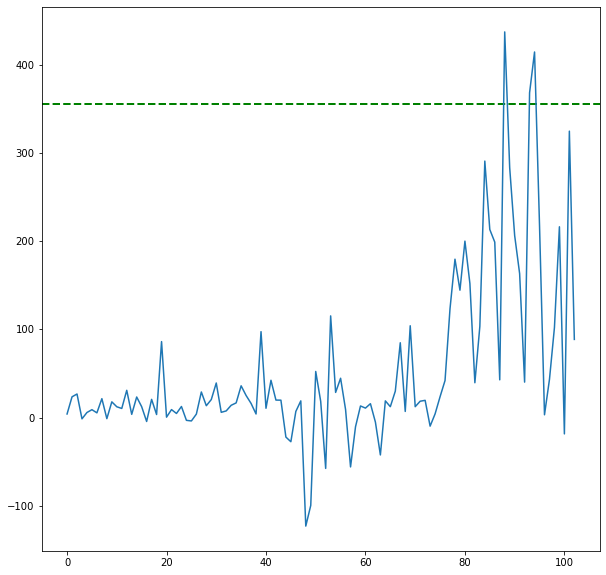

In [382]:
# 날짜별 감성점수
plt.figure(figsize=(10,10))
plt.axhline(score_today_vh, color='green', linestyle='--', linewidth=2)
plt.plot(senti_lst_vh)

## 자동차주 기사 개수 맞춘 후

### 기사 개수로 나눠주기

In [388]:
value_list = []
for i in range(len(senti_lst_vh)):
    value = senti_lst_vh[i]/df_past_c['news_vh'].iloc[i]
    value_list.append(value)
value_list

[3.9999999999999987,
 23.50000000000005,
 13.350000000000032,
 -1.4999999999999993,
 5.699999999999994,
 8.899999999999999,
 5.299999999999998,
 10.700000000000017,
 -1.3000000000000018,
 17.800000000000022,
 12.20000000000001,
 5.150000000000001,
 30.900000000000073,
 3.5999999999999988,
 23.30000000000006,
 12.30000000000001,
 -4.500000000000004,
 20.60000000000003,
 3.399999999999999,
 28.733333333333146,
 0.39999999999999597,
 8.999999999999995,
 4.5999999999999925,
 12.500000000000009,
 -3.200000000000002,
 -1.9499999999999966,
 3.899999999999998,
 29.00000000000006,
 13.400000000000006,
 20.400000000000023,
 19.59999999999998,
 5.899999999999998,
 7.499999999999994,
 13.900000000000027,
 16.60000000000002,
 18.000000000000007,
 25.000000000000068,
 16.000000000000025,
 3.9999999999999964,
 24.374999999999794,
 10.5,
 42.299999999999855,
 19.80000000000003,
 19.70000000000003,
 -22.19999999999997,
 -27.499999999999986,
 6.899999999999996,
 9.450000000000015,
 -61.65000000000016,
 

In [390]:
score_today_vh

356.6000000000095

In [392]:
len(df)

11

In [393]:
# 당일 점수
today_sc = score_today_vh/len(df)
today_sc

32.41818181818268

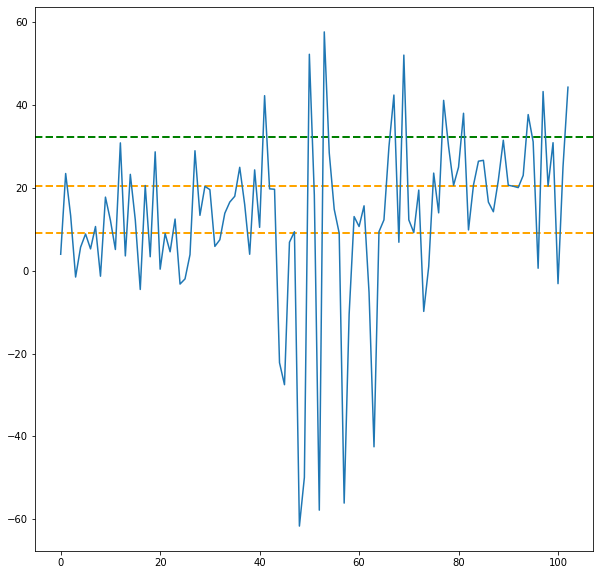

In [406]:
# 날짜별 감성점수
plt.figure(figsize=(10,10))
plt.axhline(today_sc, color='green', linestyle='--', linewidth=2)
plt.axhline(20.4298 , color='orange', linestyle='--', linewidth=2)
plt.axhline(9.066, color='orange', linestyle='--', linewidth=2)
plt.plot(value_list)

{'whiskers': [<matplotlib.lines.Line2D at 0x23f004655b0>,
 'caps': [<matplotlib.lines.Line2D at 0x23f0206a6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23f00465f70>],
 'medians': [<matplotlib.lines.Line2D at 0x23f0206af70>],
 'fliers': [<matplotlib.lines.Line2D at 0x23f01f8d2b0>],
 'means': []}

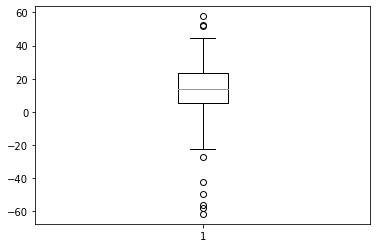

In [399]:
plt.boxplot(value_list)

In [403]:
np.percentile(value_list,[0, 25, 75, 100])

array([-61.65 ,   5.225,  23.55 ,  57.7  ])

In [405]:
np.percentile(value_list,[0, 33, 66,100])

array([-61.65  ,   9.066 ,  20.4298,  57.7   ])

### 자동차주 가격과 비교

In [210]:
df_vh = pd.read_csv('./data/변동률/자동차_지수.csv',index_col=0)
df_vh.head()

,Date,기아,쌍용차,현대차,KR모터스,total,지수,전일비
0,2008-01-02,2.499566e+14,1.664925e+14,9.305741e+14,2.587532e+12,1.349611e+15,100.000000,NaN
1,2008-01-03,2.522153e+14,1.715719e+14,9.645367e+14,2.504180e+12,1.390828e+15,103.054013,3.054013
2,2008-01-04,2.502076e+14,1.749582e+14,9.563856e+14,2.490590e+12,1.384042e+15,102.551201,-0.502812
3,2008-01-07,2.494547e+14,1.746760e+14,9.305741e+14,2.407691e+12,1.357113e+15,100.555847,-1.995354
4,2008-01-08,2.481999e+14,1.679035e+14,9.387251e+14,2.324339e+12,1.357153e+15,100.558832,0.002985


In [211]:
df_vh1 = df_vh[['Date','전일비']]
df_vh1['Date'] = df_vh1['Date'].astype('datetime64')
df_vh2 = df_vh1.set_index('Date')
df_vh2.head()

C:\Users\21ckw\AppData\Local\Temp/ipykernel_4760/1825145356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vh1['Date'] = df_vh1['Date'].astype('datetime64')


,전일비
Date,
2008-01-02,NaN
2008-01-03,3.054013
2008-01-04,-0.502812
2008-01-07,-1.995354
2008-01-08,0.002985


In [228]:
vh_diff = df_oil2['2020-08-27':]
vh_diff

,전일비
Date,
2020-08-27,-2.947757
2020-08-28,0.631020
2020-08-31,-3.560377
2020-09-01,1.138313
2020-09-02,0.165953
...,...
2022-04-13,2.430165
2022-04-14,1.103000
2022-04-15,-0.340995


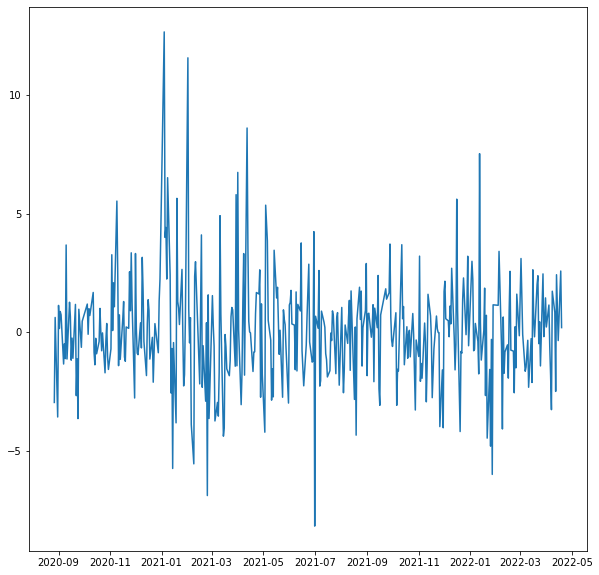

In [229]:
plt.figure(figsize=(10,10))
plt.plot(vh_diff['전일비'])

# 감성점수 정규화

### 모듈사용

In [83]:
from sklearn.preprocessing import MinMaxScaler

In [84]:
# 정규화 값
scaler_m = MinMaxScaler()
score_scaled = scaler_m.fit_transform(df_score)[0]
score_scaled

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
senti_words = df_score.columns
senti_words

Index(['said', 'hi', 'biden', 'shoot', 'wa', 'year', 'survivor', 'ha',
       'support', 'presid',
       ...
       'hillbilli', 'unannounc', 'thuggeri', 'theatr', 'frigat', 'behaviour',
       'blanchard', 'vaca', 'cabeza', 'ira'],
      dtype='object', length=12310)

In [86]:
print(senti_words[0])
print(score_scaled[0])

said
0.0


In [87]:
# 수정된 값으로 딕셔너리 만들기

scaled_dic = dict()
for i in range(len(senti_words)):
    scaled_dic[senti_words[i]] = score_scaled[i]
    
scaled_dic

{'said': 0.0,
 'hi': 0.0,
 'biden': 0.0,
 'shoot': 0.0,
 'wa': 0.0,
 'year': 0.0,
 'survivor': 0.0,
 'ha': 0.0,
 'support': 0.0,
 'presid': 0.0,
 'peopl': 0.0,
 'kill': 0.0,
 'therapi': 0.0,
 'state': 0.0,
 'repeal': 0.0,
 'war': 0.0,
 'columbin': 0.0,
 'decad': 0.0,
 'care': 0.0,
 'mass': 0.0,
 'mental': 0.0,
 'republican': 0.0,
 'author': 0.0,
 'martin': 0.0,
 'one': 0.0,
 'hous': 0.0,
 'day': 0.0,
 'repres': 0.0,
 'effort': 0.0,
 'group': 0.0,
 'aumf': 0.0,
 'health': 0.0,
 'unit': 0.0,
 'korea': 0.0,
 'famili': 0.0,
 'gha': 0.0,
 'immedi': 0.0,
 'border': 0.0,
 'wilson': 0.0,
 'would': 0.0,
 'vote': 0.0,
 'befor': 0.0,
 'trauma': 0.0,
 'provid': 0.0,
 'committe': 0.0,
 'pass': 0.0,
 'democrat': 0.0,
 'form': 0.0,
 'mani': 0.0,
 'like': 0.0,
 'children': 0.0,
 'north': 0.0,
 'need': 0.0,
 'still': 0.0,
 'seek': 0.0,
 'mexico': 0.0,
 'trump': 0.0,
 'believ': 0.0,
 'attack': 0.0,
 'also': 0.0,
 'movi': 0.0,
 'plan': 0.0,
 'la': 0.0,
 'thursday': 0.0,
 'know': 0.0,
 'think': 0.0,
 'giv

### 직접 구하기

In [88]:
df_score

,said,hi,biden,shoot,wa,year,survivor,ha,support,presid,...,hillbilli,unannounc,thuggeri,theatr,frigat,behaviour,blanchard,vaca,cabeza,ira
0,389.353086,74.531397,558.81859,-5.4493,-198.130405,-98.257153,11.776265,54.893391,-96.512477,148.180346,...,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995,-0.340995


In [91]:
senti_words = df_score.columns
senti_words

Index(['said', 'hi', 'biden', 'shoot', 'wa', 'year', 'survivor', 'ha',
       'support', 'presid',
       ...
       'hillbilli', 'unannounc', 'thuggeri', 'theatr', 'frigat', 'behaviour',
       'blanchard', 'vaca', 'cabeza', 'ira'],
      dtype='object', length=12310)

In [93]:
# 정규화
score_scaled = (df_score.iloc[0]-df_score.iloc[0].mean())/df_score.iloc[0].std()
score_scaled

said         19.164468
hi            3.644637
biden        27.518644
shoot        -0.298188
wa           -9.796829
               ...    
behaviour    -0.046363
blanchard    -0.046363
vaca         -0.046363
cabeza       -0.046363
ira          -0.046363
Name: 0, Length: 12310, dtype: float64

In [81]:
# 전체 평균
((df_score.iloc[0] - df_score.iloc[0].mean())/df_score.iloc[0].std()).mean()

-4.0211425668610194e-16

In [82]:
# 전체 표준편차
((df_score.iloc[0] - df_score.iloc[0].mean())/df_score.iloc[0].std()).std()

1.0000000000000033

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        4.000e+00, 1.000e+01, 5.000e+00, 1.000e+01, 3.000e+01, 6.900e+01,
        2.370e+02, 4.621e+03, 6.787e+03, 3.200e+02, 1.130e+02, 4.400e+01,
        2.100e+01, 1.000e+01, 1.000e+01, 1.000e+00, 1.000e+00, 6.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-29.95323177, -28.80379426, -27.65435674, -26.50491923,
        -25.35548171, -24.2060442 , -23.05660668, -21.90716916,
        -20.75773165, -19.60829413, -18.45885662, -17.3094191 ,
        -16.15998159, -15.01054407, -13.86110656, -12.71166904,
        -11.56223153, -10.41279401,  -9.26335649,  -8.11391898,
         -6.96448146,  -5.81504395,  -4.66560643,  -3.51

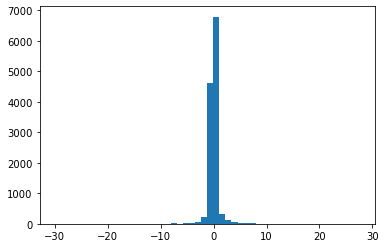

In [97]:
plt.hist((df_score.iloc[0] - df_score.iloc[0].mean())/df_score.iloc[0].std(), bins=50)

In [94]:
# 수정된 값으로 딕셔너리 만들기

scaled_dic = dict()
for i in range(len(senti_words)):
    scaled_dic[senti_words[i]] = score_scaled[i]
    
scaled_dic

{'said': 19.164467534193975,
 'hi': 3.6446368309080115,
 'biden': 27.518644000763857,
 'shoot': -0.29818833026788116,
 'wa': -9.796829083570781,
 'year': -4.873356456258251,
 'survivor': 0.5509839840964686,
 'ha': 2.6765379432588423,
 'support': -4.7873488432337234,
 'presid': 7.275324514974114,
 'peopl': -3.231317499106064,
 'kill': -1.053819922152019,
 'therapi': 0.42098406731220345,
 'state': 19.011969548698318,
 'repeal': 0.38751570550454184,
 'war': -1.876429013728958,
 'columbin': 0.333299867307142,
 'decad': 1.6928474275895393,
 'care': -2.0172590175674214,
 'mass': -0.455249026879184,
 'mental': 1.1051549285989668,
 'republican': -11.52502940821226,
 'author': -1.9022626723578893,
 'martin': 1.2911520484359171,
 'one': 6.612349333958623,
 'hous': -8.321232628257619,
 'day': 2.4737612817154266,
 'repres': -7.610899884055083,
 'effort': -0.43786336758581856,
 'group': 6.293886530881439,
 'aumf': -0.9379444892170136,
 'health': -1.5856176332166356,
 'unit': 2.13502385907582,
 'kor

In [98]:
# 감성점수 리스트

senti_scaled_lst = []

for d in range(len(df_merge1['date'])):
    news_words = df_merge1['clean_news'][d]

    senti_score = 0
    for word in news_words:
        if word in scaled_dic.keys():
            senti_score += scaled_dic[word]
        else:
            continue
    
    senti_scaled_lst.append(senti_score)
        
senti_scaled_lst

[1404.383717392739,
 3780.937503038315,
 505.72411996892674,
 2680.9798535518594,
 1149.6104633268876,
 3435.109059923178,
 825.6458138415965,
 249.40175547260182,
 45.23928857938601,
 2399.7365405739506,
 2832.3154580804962,
 1667.6380619878425,
 1544.9598325604497,
 2471.3541927245533,
 3441.0952665998734,
 1340.6685787418623,
 2792.659082673125,
 1205.4063780341169,
 2278.635731517222,
 2118.4851619372303,
 3870.36549541464,
 1548.609100906806,
 2850.7163258005476,
 4931.799269161268,
 1460.0655000723966,
 4113.92083393388,
 1627.4392557609885,
 1835.978521051553,
 -17.013252930743583,
 631.7653629808406,
 1306.5063034295347,
 325.47698364105594,
 -463.58113183570765,
 -152.05516333158172,
 -364.81635013300706,
 -261.61687851712463,
 2214.208936887035,
 2395.0069805881903,
 -17.98741959178618,
 949.5159655812438,
 483.7582858696994,
 1568.6101461687613,
 487.31271100657926,
 478.97458509298156,
 585.7230708402843,
 807.7687739600264,
 1911.1372504266826,
 430.05274846535553,
 674.67

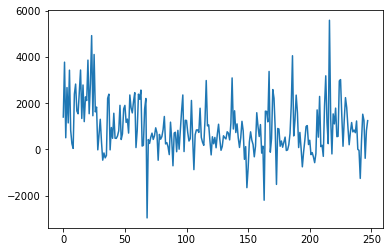

In [99]:
plt.plot(senti_scaled_lst)

## 감성점수 총합 정규화

In [100]:
senti_dic

{'said': 389.35308557722817,
 'hi': 74.53139672073345,
 'biden': 558.8185903558245,
 'shoot': -5.449300223625741,
 'wa': -198.13040486755742,
 'year': -98.25715256197174,
 'survivor': 11.776265392999207,
 'ha': 54.89339082900193,
 'support': -96.51247747468715,
 'presid': 148.1803462654059,
 'peopl': -64.94818885340777,
 'kill': -20.777380694240563,
 'therapi': 9.139200972924002,
 'state': 386.25964504563836,
 'repeal': 8.460291106638067,
 'war': -37.464108045211404,
 'columbin': 7.360516110995746,
 'decad': 34.93910683094536,
 'care': -40.32086212312183,
 'mass': -8.635295915555476,
 'mental': 23.017691668772713,
 'republican': -233.1871625917752,
 'author': -37.98814701151149,
 'martin': 26.79066629130611,
 'one': 134.73181257018678,
 'hous': -168.19774793245375,
 'day': 50.78004112382354,
 'repres': -153.7885601999766,
 'effort': -8.28262566255703,
 'group': 128.27175514948922,
 'aumf': -18.42683317919247,
 'health': -31.564963157490837,
 'unit': 43.908710533102706,
 'korea': 6.9234

In [106]:
senti_lst1 = pd.Series(senti_lst)
senti_lst1

0      29299.203639
1      78771.010773
2      10708.891177
3      55656.119948
4      24421.248321
           ...     
243    31677.936203
244    25951.324787
245    -7097.379823
246    17049.274599
247    25946.644182
Length: 248, dtype: float64

In [112]:
# Minmaxscale

senti_scaled_lst1 = (senti_lst1- senti_lst1.mean())/senti_lst1.std()
senti_scaled_lst1

0      0.410996
1      2.563391
2     -0.397823
3      1.557720
4      0.198768
         ...   
243    0.514488
244    0.265338
245   -1.172529
246   -0.121968
247    0.265134
Length: 248, dtype: float64

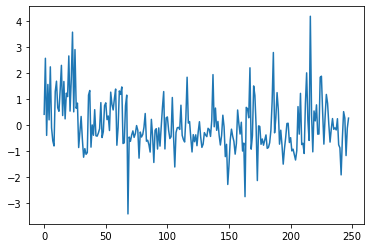

In [113]:
plt.plot(senti_scaled_lst1)